# 生成されるテキストのフォーマットをコントロールしやすくしてくれるライブラリ Instructor を試してみた

## Openai の function_call を抽象化してくれるライブラリ Instructor とは？

- Openai の API を使うと、プロンプトに対して、解答となる文章を生成できる。
- アウトプットとなる文章のフォーマットを指定したい場合、GPT-3.5 等が生成した文章をそのまま使うと、プロンプトでフォーマットを指定したとしても、フォーマット通り生成されないことが多々ある。
- Openai が 2023 年 6 月 13 日にリリースした `function_calling` の API を使えば、任意のツールを関数として定義し、その関数の引数を LLM モデルに生成させることができる。
- 関数の定義は JSON 形式で行う必要があるが、コードが読みづらくメンテしずらい
- そこで、Instructor というライブラリを使うと、関数の定義を Python のコードで簡潔に書くことができる。

OpenAI の API は、プロンプトに対する解答を文章として生成する強力なツールです。しかし、出力される文章のフォーマットを指定したい場合、GPT-3.5 などのモデルが生成した文章をそのまま使用すると、プロンプトでフォーマットを指定したにも関わらず、フォーマット通りに生成されないことがしばしばあります。

この問題を解決するために、OpenAI は 2023 年 6 月 13 日に function_calling という新しい API をリリースしました。この API を使用すると、任意のツールを関数として定義し、その関数の引数を LLM モデルに生成させることができます。これにより、より具体的で制御可能な出力を得ることが可能になります。

ただし、関数の定義は JSON 形式で行う必要があり、コードが読みづらくメンテナンスが難しいという問題があります。これを解決するために、Instructor というライブラリが開発されました。Instructor を使用すると、関数の定義を Python のコードで簡潔に書くことができます。これにより、コードの可読性が向上し、メンテナンスも容易になります。

今回はこの Instructor のライブラリを触るのが初めてだったので、試してみた結果を共有させていただければと思います。


まずは [Getting Started](https://jxnl.github.io/instructor/) の通りにやってみます。


In [18]:
!pip install pip openai instructor graphviz -Uqq

In [4]:
# Colab上でテキストが見やすいようにwrapしておく
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### セットアップ

open_api_key を下記に入力

In [5]:
OPENAI_API_KEY = "YOUR_API_KEY"


In [6]:
import openai
from pydantic import BaseModel
import instructor

openai.api_key = OPENAI_API_KEY

# Patch the OpenAI API to use the `ChatCompletion`
# endpoint with `response_model` enabled.
instructor.patch()

In [1]:
# obtain the versions of the openai and instructor packages
!pip freeze | grep -E '^openai|^instructor'

instructor==0.2.7
openai==0.27.10


### 情報の抽出

まずは抽出したいエンティティーの情報を定義

In [7]:
# まずは抽出したいエンティティーの情報を定義

class UserDetail(BaseModel):
    name: str
    age: int

In [8]:
user: UserDetail = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    response_model=UserDetail,
    messages=[
        {"role": "user", "content": "Jason Bourneは５３歳の男性です。"},
    ]
)
user

UserDetail(name='Jason Bourne', age=53)

無事名前と年齢が抽出されました。

もう少し複雑なインプットを試してみる。試しに[Wikipediaの「テイラー・スウィフト」に関するエントリー](https://ja.wikipedia.org/wiki/%E3%83%86%E3%82%A4%E3%83%A9%E3%83%BC%E3%83%BB%E3%82%B9%E3%82%A6%E3%82%A3%E3%83%95%E3%83%88)を使います。

In [9]:
content = """
テイラー・アリソン・スウィフト（英語: Taylor Alison Swift、1989年12月13日 - ）は、米国のシンガーソングライター[4]。グラミー賞を12回受賞（46回ノミネート）している[5]。
カルヴィン・ハリスと共にリアーナの楽曲「This Is What You Came For」を作詞した際には、ニルス・ショーベリ（英語: Nils Sjöberg）というペンネームを使用した。
ファンは総称して、スウィフティーズ（英語: Swifties）と呼ばれる。

生い立ち
1989年12月13日、ペンシルベニア州ウエスト・レディングで生まれた[6]。父親は銀行のファイナンシャル・アドバイザーである[7][8]。父はペンシルベニア州で育ち、祖先は3代にわたる銀行頭取であった[9][10]。母親は投資信託のマーケティング管理であったが、退職後専業主婦となった[11]。母はアメリカ人であるが東南アジアを中心にエンジニアとして働いていた父親（テイラーの祖父）と10歳までシンガポールで過ごし、帰国後テキサス州に居住した[10]。テイラーには弟がいる[12]。
"""

user: UserDetail = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    response_model=UserDetail,
    messages=[
        {"role": "user", "content": content},
    ]
)
user

UserDetail(name='テイラー・アリソン・スウィフト', age=31)

年齢が明示されていなくても推測してくれるみたいです。1989年生まれなので2023年であれば３４歳なはずですが、年齢がずれているのはGPT-3.5のトレーニングのカットオフ時期の影響でしょうか。

In [10]:
content = "今日の日付は2023年9月16日。\n\n"  + content

user: UserDetail = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    response_model=UserDetail,
    messages=[
        {"role": "user", "content": content},
    ]
)
user

UserDetail(name='テイラー・アリソン・スウィフト', age=33)

今日の日付をちゃんと入れてあげると(恐らく)正しい年齢が計算されました。

### OpenAISchemaを使った指定

上記では `instructor.patch()` を使うことで `response_model` の kwarg を使えるようにしましたが、`OpenAISchema` を使うと直接 OpenAI の schema の生成だけ行うことができます。

これを `openai.ChatCompletion.create()` に対し、 `functions` と `function_call` の kwarg として入力することで、普通の function calling 同様に扱うことが出来ます。

より細かい設定が必要な際には、直接的にこの方法を使うと良いのかもしれません。

初めは上記と同様、モデルの型定義を行います。

In [11]:
from instructor import OpenAISchema
from pydantic import Field

class UserDetails(OpenAISchema):
    """"
    Userに関して抽出した情報
    """
    name: str = Field(..., description="User's full name")
    age: int
    gender: str = Field(..., description="User's gender: Choose from '男性', '女性', 'その他'")
    birthday: str = Field(..., description="User's birthday in YYYY-MM-DD format.")

# 生成される openai_schema を確認
UserDetails.openai_schema

{'name': 'UserDetails',
 'description': '"\nUserに関して抽出した情報',
 'parameters': {'properties': {'name': {'description': "User's full name",
    'type': 'string'},
   'age': {'type': 'integer'},
   'gender': {'description': "User's gender: Choose from '男性', '女性', 'その他'",
    'type': 'string'},
   'birthday': {'description': "User's birthday in YYYY-MM-DD format.",
    'type': 'string'}},
  'required': ['age', 'birthday', 'gender', 'name'],
  'type': 'object'}}

response_model を使わずに、通常の function calling を行います。

In [48]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    functions=[UserDetails.openai_schema],
    function_call={"name": UserDetails.openai_schema["name"]},
    messages=[
        {"role": "system", "content": "与えられた情報からユーザー情報を抽出してください"},
        {"role": "user", "content": content},
    ]
)
completion

<OpenAIObject chat.completion id=chatcmpl-807toGzWDsvBeedEh5foMFB1D5UrG at 0x13128f890> JSON: {
  "id": "chatcmpl-807toGzWDsvBeedEh5foMFB1D5UrG",
  "object": "chat.completion",
  "created": 1695041056,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "UserDetails",
          "arguments": "{\n  \"name\": \"\u30c6\u30a4\u30e9\u30fc\u30fb\u30a2\u30ea\u30bd\u30f3\u30fb\u30b9\u30a6\u30a3\u30d5\u30c8\",\n  \"age\": 33,\n  \"gender\": \"\u5973\u6027\",\n  \"birthday\": \"1989-12-13\"\n}"
        }
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 598,
    "completion_tokens": 51,
    "total_tokens": 649
  }
}

返り値の `completion` オブジェクトから user の情報を抽出。

In [13]:
# 返り値の `completion` オブジェクトから user の情報を抽出
user = UserDetails.from_response(completion)
user

UserDetails(name='テイラー・アリソン・スウィフト', age=33, gender='女性', birthday='1989-12-13')

上記の例であれば response_model で実行も可能です。response_modelが結構便利なため、普段は直接response_modelを使った使い方で良い気がしました。

In [49]:
user = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    response_model=UserDetails,
    messages=[
        # {"role": "system", "content": "Extract user details from the content"},
        {"role": "user", "content": content},
    ]
)
user

UserDetails(name='テイラー・アリソン・スウィフト', age=33, gender='女性', birthday='1989-12-13')

### テキストの分類

使用法の例に関してはこちらの[リンク](https://jxnl.github.io/instructor/examples/)が役立ちました。
テキスト分類がライブラリの肌感を把握するのに良さそうだったので、試してみます。

スパム判定

In [57]:
from enum import Enum
from pydantic import BaseModel

class Labels(str, Enum):
    "スパム判定のテキスト分類用のラベル"
    SPAM = 'spam'
    NOT_SPAM = 'not_spam'

class SpamClassification(BaseModel):
    "Classification of the text as spam or not_spam"
    class_label: Labels = Field(..., description="The label spam or not_spam")


In [58]:
import openai
import instructor

# OpenAI API の `ChatCompletion`
# エンドポイントをパッチし、 `response_model` を有効にする。
instructor.patch()

def classify(data: str) -> SpamClassification:
    """インプットテキストに対してスパムかそうでないかの判定を一つだけ返す関数"""
    return openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        response_model=SpamClassification,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text as spam or not_spam: {data}",
            },
        ],
    )

# ナイジェリアの手紙の詐欺の例 (wikipedia より)
nigerian_letter = """財産取得のための援助のお願い

このたびは、あなたの住む国において資産や不動産を取得
したいという望みを、ナイジェリア連邦労働住宅省の契約
及び資産配分局長に代わり、あなたにお知らせいたしたく
お手紙差し上げました。

彼の非常に戦略的に重要で影響力の強い地位を考慮いたし
ますと、彼はこの取引を可能な限り内密にしたいと望んで
いるでしょう。彼はさらに、少なくとも取引が完了する前の
今の時点では、取引における彼の正体を非公開にしたいと
考えております。それゆえ、われわれは海外における代理人
を求めております。

そこで、この取引を実現するため、私はあなたがわれわれの
海外代理人として振舞うことに同意するよう問い合わせる
ようにと指示されました。

この取り決めは、手短にいえば、われわれがあなたの国で
計画している投資を遂行する意図で用意したファンドが現在、
ナイジェリアン・エイペックス・バンク（＝ナイジェリア中央銀行）
の暗号化された口座にあり、われわれはこの資金をあなたの
国で使う前に、あなたの国の使い勝手のよい口座に移すために、
口座をご用意いただくなどのあなたの助力が必要なのです。

この契約により、わが省からあなたにいくぶんかの支払がある
でしょうから、あなたにはナイジェリア連邦労働住宅省のために
契約を遂行していただけるだろうと考えております。
この契約は総額2640万米ドルにのぼり、あなたがわれわれの
海外代理人になることをご了解いただいた場合、あなたの
取り分は30%になるでしょう。

支払いが発効し次第、そして上述の集金が成功裏にあなたの口座に
入金し次第、われわれは自分たちの取り分を海外のいくつかの
資産を取得することに使うつもりです。この件に関しても、あなた
はわれわれの代理人として動いてほしいのです。

これに照らして、わたしは以下の情報をお教えいただきたいのです。
1. あなたの会社の名前と住所（もしあれば）
2. あなた個人のファックス番号
3. 連絡のため、あなたの個人の電話番号

この提案の受け入れについて、上にあげたわたしの電子メール
アドレスを通してお知らせください。その後、われわれはこの
取引について形態などを議論したいと思います。

あなたのご回答が早ければ早いほど助かります。あなたのご協力を
お待ちしております。ありがとうございました。
"""

classify(nigerian_letter)

SpamClassification(class_label=<Labels.SPAM: 'spam'>)

In [59]:
classify("君のことを愛しているよ")

SpamClassification(class_label=<Labels.NOT_SPAM: 'not_spam'>)

In [60]:
classify("""
鈴木様

お世話になっております。不動商事の長須賀です。

昨日調整したミーティングに関してですが、大変申し訳ございませんが緊急の用事が入ってしまいまして、
参加できなくなってしまいました。大変申し訳ございません。

また後日別の日程で再度調整可能でしょうか。ご検討のほどよろしくお願いいたします。

不動商事
長須賀
""")

SpamClassification(class_label=<Labels.NOT_SPAM: 'not_spam'>)

上記の例ではうまくいく走るよう調整を行いましたが、定義の仕方次第ではうまく行かない例もありました。結局はモデルが function calling を適切に行なってくれるようチューニングが必要となります。

参考までに、Instructorを使わなかった場合:

In [68]:
res = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": f"次のテキストを「スパム」か「スパムではない」かのどちらかに分類してください:\n\n{nigerian_letter}",
        },
    ],
)
res

<OpenAIObject chat.completion id=chatcmpl-808GfWIdvfUDX4LCa36HH9tPj2TxD at 0x1312faab0> JSON: {
  "id": "chatcmpl-808GfWIdvfUDX4LCa36HH9tPj2TxD",
  "object": "chat.completion",
  "created": 1695042473,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "\u30b9\u30d1\u30e0\u3067\u306f\u306a\u3044"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 1054,
    "completion_tokens": 6,
    "total_tokens": 1060
  }
}

In [69]:
res['choices'][0]['message']['content']

'スパムではない'

（スパムではないと出てしまいますね…）

LLMからの返り値をその後も何かのプログラムなどで使いたい場合は、ここから解答を正規化していくのが必要となります。そのため、手法としてOpenAIのfunction_callingを使って正規化をする手法が生まれています。この一連の流れをより簡単に・直感的に行うために、Instructorというライブラリが開発されました。

### ナレッジグラフの生成

直近で @yoheinakajima さんの Instagraph が Twitter で話題になっていました。これは OpenAI の function_call を使ってナレッジグラフを生成するものです。[github](https://github.com/yoheinakajima/instagraph)

それを受けて @jxnlco さんが Instructor を使ってナレッジグラフを生成する例を公開していました。[リンク](https://jxnl.github.io/instructor/examples/knowledge_graph/)
下記ではそのナレッジグラフの可視化を少しアレンジして試してみたいと思います。

In [70]:
from pydantic import BaseModel, Field
from typing import List
import openai
import instructor

instructor.patch()

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)
    edges: List[Edge] = Field(..., default_factory=list)

In [74]:
def generate_graph(input: str, model: str = "gpt-3.5-turbo") -> KnowledgeGraph:
    return openai.ChatCompletion.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f"下記の文章について、詳細なナレッジグラフを生成してください:\n\n{input}",
            }
        ],
        response_model=KnowledgeGraph,
    )


In [72]:
from graphviz import Digraph

def visualize_knowledge_graph(kg: KnowledgeGraph):
    dot = Digraph(comment="Knowledge Graph", )

    # Add nodes
    for node in kg.nodes:
        dot.node(str(node.id), node.label, color=node.color)

    # Add edges
    for edge in kg.edges:
        dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

    # Render the graph
    dot.render("knowledge_graph.gv", view=True)
    return dot


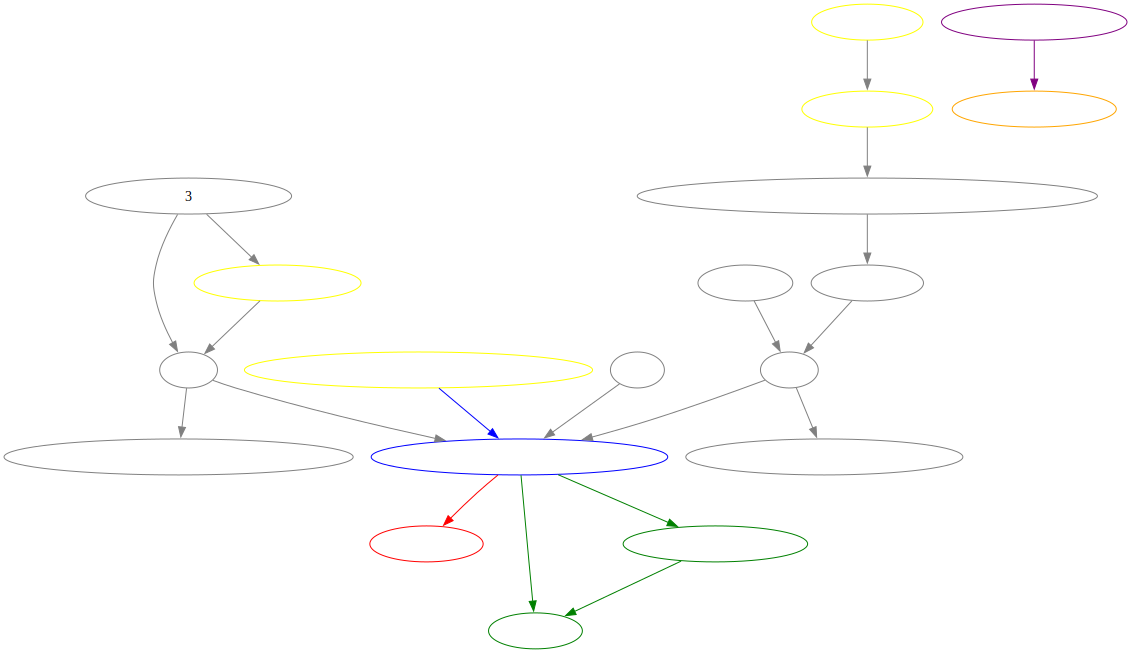

In [73]:
graph = generate_graph(content) # テイラー・スウィフトのテキストを再利用
visualize_knowledge_graph(graph)

情報の構造を可視化してくれるのでわかりやすいですね。どの程度ハルシネーションが混じるかは検証できていません。

また、modelを gpt-4 に変えてみるとアウトプットが変わりましたが、今回に関してはgpt-3.5よりも良くなったとも言い難かったです。

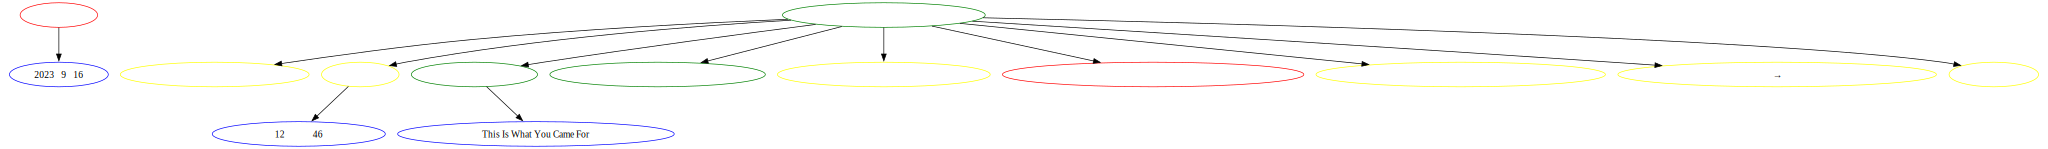

In [75]:
graph = generate_graph(content, model="gpt-4")
visualize_knowledge_graph(graph)

### ニュース記事の構造化

ニュース記事の構造化を試してみたいと思います。
今回使う記事は[こちらの記事](https://jp.reuters.com/world/ukraine/6AA6RMYF35PQLNJJ2WBV5V2T4E-2023-09-16/)となります。

記事の中身はこんな具合です。ここからどんな情報を抽出できるか試してみたいと思います。


In [78]:
article = """
[１６日　ロイター] - 米政府が１４日発表した対ロシア追加制裁に、北極圏の液化天然ガス（ＬＮＧ）プロジェクト「アークティック２」に関わる同国企業が新たに含まれた。同プロジェクトには日本企業も出資しており、影響が及ぶ可能性がある。

追加制裁対象は計１５０以上の個人や企業で、ロシア軍艦艇の整備を請け負う企業や自動車メーカー、軍民両用品の対ロ輸入を支援するトルコ企業５社などが含まれる。

将来的にロシアにエネルギー収入をもたらすとして、北極海のＬＮＧプロジェクト「アークティック２」の建設やＬＮＧ運搬などに関わる企業も制裁対象に列挙した。

アークティック２は日本の三井物産(8031.T)や独立行政法人エネルギー・金属鉱物資源機構（ＪＯＧＭＥＣ）が権益を持ち、最終的に年間２００万トンの供給を受ける見込み。米政府の制裁は出資者を対象にしていないが、日本政府関係者は「影響が出るかもしれない」と話す。出荷開始時期も遅れる可能性があるとみている。
""".strip()

ニュース記事の構造化が必要なシーンを想像しながらエンティティーを適当に定義してみます。

In [79]:
import openai
from pydantic import BaseModel, Field
import instructor
from enum import Enum

class Company(BaseModel):
    name: str = Field(..., description="会社名")
    ticker: str = Field(..., description="銘柄名")

class NewsArticleTopics(str, Enum):
    ECONOMICS = '経済'
    BUSINESS = 'ビジネス'
    FINANCE = '金融'

class NewsArticleSummary(BaseModel):
    summary: str = Field(..., description="A short summary of what the article is about")
    companies_mentioned: list[Company] = Field(..., description="Company names mentioned in the article")
    audience: str = Field(..., description="The article's intended audience / who the article may impact the most")
    topic: NewsArticleTopics = Field(..., description="The topic of the news article", )

response_model を使って、ニュース記事の構造化を試してみます。

In [80]:
summary: NewsArticleSummary = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": f"下記のニュース記事を正確に構造化してください: {article}",
        }
    ],
    response_model=NewsArticleSummary,
) # type: ignore
summary

NewsArticleSummary(summary='米政府が14日に発表した対ロシア追加制裁に、北極圏の液化天然ガス（LNG）プロジェクト「アークティック2」に関わる企業が新たに含まれた。同プロジェクトには日本企業も出資しており、影響が及ぶ可能性がある。', companies_mentioned=[Company(name='三井物産', ticker='8031.T'), Company(name='独立行政法人エネルギー・金属鉱物資源機構（JOGMEC）', ticker='')], audience='日本企業、エネルギー業界', topic=<NewsArticleTopics.ECONOMICS: '経済'>)

In [81]:
# GPT-4の場合
summary: NewsArticleSummary = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {
            "role": "user",
            "content": f"下記のニュース記事を正確に構造化してください: {article}",
        }
    ],
    response_model=NewsArticleSummary,
) # type: ignore
summary

NewsArticleSummary(summary='米政府が14日に発表した対ロシアの追加制裁に、北極圏の液化天然ガス（LNG）プロジェクト「アークティック2」に関わるロシア企業が新しく含まれた。このプロジェクトには日本の三井物産や独立行政法人エネルギー・金属鉱物資源機構（JOGMEC）も出資している。制裁は出資者を対象にはしていないが、影響が出る可能性があると日本政府関係者は述べた。', companies_mentioned=[Company(name='三井物産', ticker='8031.T'), Company(name='独立行政法人エネルギー・金属鉱物資源機構', ticker='')], audience='三井物産の投資家、独立行政法人エネルギー・金属鉱物資源機構の関係者、政治経済に関心のある一般公', topic=<NewsArticleTopics.ECONOMICS: '経済'>)

慣れてくると結構サクサクかけます。

In [ ]:
from pydantic import Field, BaseModel
from typing import List

content = """
海賊王を夢見る少年モンキー・D・ルフィを主人公とする、「ひとつなぎの大秘宝（ワンピース）」を巡る海洋冒険ロマン。

夢への冒険・仲間たちとの友情といったテーマを前面に掲げ、バトルやギャグシーン、感動エピソードをメインとする少年漫画の王道を行く物語として人気を博している[3]。また、長年にわたりながら深く練り込まれた壮大な世界観・巧緻な設定のストーリーも特徴。

2023年7月の時点で単行本は第106巻まで刊行されており、『週刊少年ジャンプ』歴代作品の中では『こちら葛飾区亀有公園前派出所』（1976年 - 2016年）に次ぐ長期連載となっている。国内累計発行部数は2022年時点で日本の漫画では最高となる4億1000万部を突破している[4]。また、第67巻は初版発行部数405万部[5]の国内出版史上最高記録を樹立し、第57巻（2010年3月発売）以降の単行本は初版300万部以上発行を継続する[6]など、出版の国内最高記録をいくつも保持している。

2015年6月15日には "Most Copies Published For The Same Comic Book Series By A Single Author（最も多く発行された単一作者によるコミックシリーズ）" 名義でギネス世界記録に認定された[7][8]。実績は発行部数3億2,086万6,000部（2014年12月時点）[7]。なお、このギネス世界記録は2022年7月付で同作品によって更新され[9]、日本では同年8月に「日本国内累計発行部数4億1656万6000部」と報道された[4]。

本作とともに長年ジャンプの看板作品であった『NARUTO -ナルト-』同様、海外での人気も高い[10]。海外では翻訳版が60以上の国と地域で販売されており、海外でのコミックス累計発行部数は2022年8月時点で1億部を突破、全世界累計発行部数は2022年8月の時点で5億1000万部を突破している[4]。

1999年よりテレビアニメがフジテレビ系列で放送されており、東映アニメーション製作のアニメ作品としては最長のロングラン作品になっている（詳細はONE PIECE (アニメ)を参照）。
""".strip()

class Person(BaseModel):
    name: str
    description: str = Field(..., description="人物の説明文")

class PeopleMentioned(BaseModel):
    people: List[Person] = Field(..., description="人物のリスト")

people: PeopleMentioned = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    response_model=PeopleMentioned,
    messages=[
        {"role": "user", "content": "Extract the people mentioned in the following passage:\n\n" + content},
    ],
    temperature=0.0,
)
people

PeopleMentioned(people=[Person(name='モンキー・D・ルフィ', description='主人公')])